In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.utils import resample

# Leitura dos dados

Aqui está sendo importado o dataset que será utilizado no trabalho e algumas informações sobre ele são listadas abaixo

In [3]:
dados = pd.read_csv("dados_29051.csv")
dados.drop("Unnamed: 0", axis = "columns", inplace=True)
dados.head()

CodigoReceita  Volume TipoLancamento  QuantidadeAgua  ConsumoTotal  \
0       23009051     8.0              B          1368.0        2480.0   
1       23009051     8.0              B          1368.0        2480.0   
2       23009051     8.0              B          1368.0        2480.0   
3       23009051     8.0              B          1368.0        2480.0   
4       23009051     8.0              B          1368.0        2480.0   

  TipoTraco   FCK  Rompimento7Dias  Rompimento28Dias  ResultadoEsperado  
0         N  25.0            20.66             29.42          43.601321  
1         N  25.0            21.54             32.70          43.601321  
2         N  25.0            18.46             28.26          43.601321  
3         N  25.0            19.59             30.59          43.601321  
4         N  25.0              NaN               NaN          43.601321

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7555 entries, 0 to 7554
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CodigoReceita      7555 non-null   int64  
 1   Volume             7555 non-null   float64
 2   TipoLancamento     7555 non-null   object 
 3   QuantidadeAgua     7555 non-null   float64
 4   ConsumoTotal       7555 non-null   float64
 5   TipoTraco          7555 non-null   object 
 6   FCK                7555 non-null   float64
 7   Rompimento7Dias    6955 non-null   float64
 8   Rompimento28Dias   7085 non-null   float64
 9   ResultadoEsperado  7555 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 590.4+ KB


# Transformação dos Dados

### Transformação das Colunas *QuantidadeAgua* e *ConsumoTotal*

Transformação das colunas para retornarem os valores respectivos para cada m^3 de concreto

In [5]:
dados["QuantidadeAguaM3"] = dados["QuantidadeAgua"] / dados["Volume"]

In [6]:
dados["ConsumoM3"] = dados["ConsumoTotal"] / dados["Volume"]

Com a transformação acima, as colunas iniciais se tornam dispensáveis. Abaixo elas são removidas do dataset.

In [7]:
dados.drop(["QuantidadeAgua", "ConsumoTotal"], axis = 1, inplace = True)

### Criação da nova feature *RelacaoAguaCimento*

In [8]:
dados["RelacaoAguaCimento"] = dados["QuantidadeAguaM3"] / dados["ConsumoM3"]
dados["RelacaoAguaCimento"] = dados["RelacaoAguaCimento"].round(2)

In [9]:
dados.tail()

CodigoReceita  Volume TipoLancamento TipoTraco   FCK  Rompimento7Dias  \
7550       22973051     7.0              C         E  25.0            22.80   
7551       34436051     8.0              B         E  35.0            35.26   
7552       29383051     5.5              B         N  35.0            33.38   
7553       29383051     7.0              B         N  35.0            31.91   
7554       32118051     8.0              B         E  20.0            19.97   

      Rompimento28Dias  ResultadoEsperado  QuantidadeAguaM3  ConsumoM3  \
7550             29.42          39.746215        189.000000      314.0   
7551             44.45          48.378218        195.000000      394.0   
7552             45.12          43.571436        187.090909      339.0   
7553             39.63          43.592906        187.000000      339.0   
7554             29.30          41.170939        191.000000      300.0   

      RelacaoAguaCimento  
7550                0.60  
7551                0.49  
7552                0.55  
7553                0.55  
7554                0.64

### Removendo dados faltantes da feature que será predita

Como a feature Rompimento28Dias apresenta dados faltantes, estes serão removidos abaixo.

In [10]:
mask_dados_existentes = dados["Rompimento28Dias"].notna()
dados = dados[mask_dados_existentes]

/home/marina/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rompimento28Dias', ylabel='Density'>

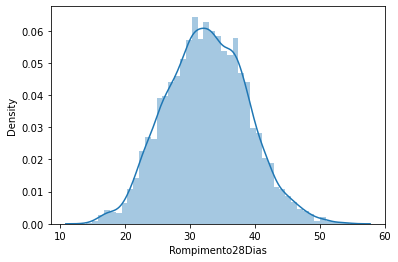

In [11]:
mask_dados_romp_7_dias_existentes = dados["Rompimento28Dias"].notna()
rompimentos_7_dias_existentes = dados[mask_dados_romp_7_dias_existentes]["Rompimento28Dias"]
sns.distplot(rompimentos_7_dias_existentes,kde=True)

In [12]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7085 entries, 0 to 7554
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CodigoReceita       7085 non-null   int64  
 1   Volume              7085 non-null   float64
 2   TipoLancamento      7085 non-null   object 
 3   TipoTraco           7085 non-null   object 
 4   FCK                 7085 non-null   float64
 5   Rompimento7Dias     6939 non-null   float64
 6   Rompimento28Dias    7085 non-null   float64
 7   ResultadoEsperado   7085 non-null   float64
 8   QuantidadeAguaM3    7085 non-null   float64
 9   ConsumoM3           7085 non-null   float64
 10  RelacaoAguaCimento  7085 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 664.2+ KB


**Análise da distribuição dos dados de Rompimento de 7 Dias**

/home/marina/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rompimento7Dias', ylabel='Density'>

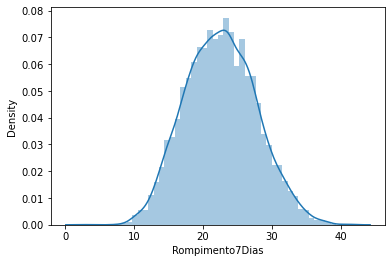

In [13]:
mask_dados_romp_7_dias_existentes = dados["Rompimento7Dias"].notna()
rompimentos_7_dias_existentes = dados[mask_dados_romp_7_dias_existentes]["Rompimento7Dias"]
sns.distplot(rompimentos_7_dias_existentes,kde=True)

**Análise de densidade de amostras por código de receita**

Análise feita a fim de entender como estavam distribuídas as amostras entre os códigos de receita.

/home/marina/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


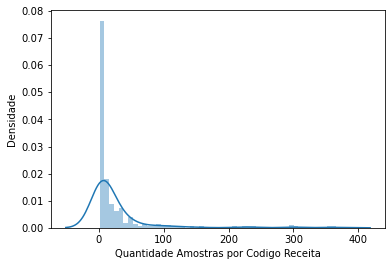

In [14]:
dados_amostras_codigo_receita = dados["CodigoReceita"].value_counts()
fig = sns.distplot(dados_amostras_codigo_receita,kde=True)
fig.set(xlabel='Quantidade Amostras por Codigo Receita', ylabel='Densidade')
plt.show()

In [15]:
print("Total de possíveis categorias na variável CodigoReceita:", len(dados["CodigoReceita"].unique()))

Total de possíveis categorias na variável CodigoReceita: 283


Após esta análise, foi decidido não utilizar tal *feature*.
Abaixo, ela é eliminada do *dataset*.

In [16]:
dados.drop("CodigoReceita", axis = "columns", inplace = True)

**Resultado final após o tratamento dos dados**

In [17]:
dados.head()

Volume TipoLancamento TipoTraco   FCK  Rompimento7Dias  Rompimento28Dias  \
0     8.0              B         N  25.0            20.66             29.42   
1     8.0              B         N  25.0            21.54             32.70   
2     8.0              B         N  25.0            18.46             28.26   
3     8.0              B         N  25.0            19.59             30.59   
5     8.0              B         N  25.0            20.19             30.20   

   ResultadoEsperado  QuantidadeAguaM3  ConsumoM3  RelacaoAguaCimento  
0          43.601321             171.0      310.0                0.55  
1          43.601321             171.0      310.0                0.55  
2          43.601321             171.0      310.0                0.55  
3          43.601321             171.0      310.0                0.55  
5          43.601321             171.0      310.0                0.55

In [18]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7085 entries, 0 to 7554
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Volume              7085 non-null   float64
 1   TipoLancamento      7085 non-null   object 
 2   TipoTraco           7085 non-null   object 
 3   FCK                 7085 non-null   float64
 4   Rompimento7Dias     6939 non-null   float64
 5   Rompimento28Dias    7085 non-null   float64
 6   ResultadoEsperado   7085 non-null   float64
 7   QuantidadeAguaM3    7085 non-null   float64
 8   ConsumoM3           7085 non-null   float64
 9   RelacaoAguaCimento  7085 non-null   float64
dtypes: float64(8), object(2)
memory usage: 608.9+ KB


**Análise da distribuição de amostras nas variáveis categóricas TipoLancamento e TipoTraco**

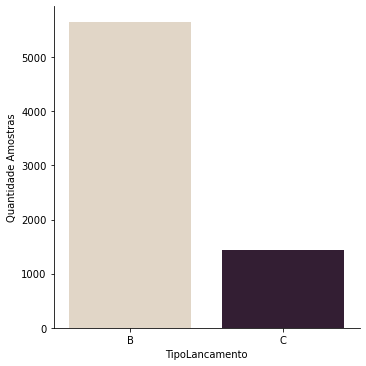

In [19]:
fig = sns.catplot(x='TipoLancamento', kind='count', palette="ch:.25", data=dados)
fig.set(ylabel='Quantidade Amostras')
plt.show()

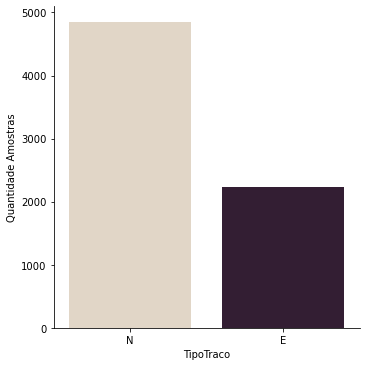

In [20]:
fig = sns.catplot(x='TipoTraco', kind='count', palette="ch:.25", data=dados)
fig.set(ylabel='Quantidade Amostras')
plt.show()

# Análise Exploratória

In [21]:
dados_modelo = dados.drop("ResultadoEsperado", axis = "columns")

In [22]:
dados_modelo.describe()

Volume          FCK  Rompimento7Dias  Rompimento28Dias  \
count  7085.000000  7085.000000      6939.000000       7085.000000   
mean      7.266337    26.897671        22.583956         32.554786   
std       1.049079     4.731808         5.155209          6.254058   
min       3.000000    15.000000         2.710000         14.030000   
25%       7.000000    25.000000        18.880000         28.170000   
50%       8.000000    25.000000        22.520000         32.500000   
75%       8.000000    30.000000        26.105000         36.870000   
max      10.000000    40.000000        41.650000         54.570000   

       QuantidadeAguaM3    ConsumoM3  RelacaoAguaCimento  
count       7085.000000  7085.000000         7085.000000  
mean         174.042941   320.496824            0.552790  
std           19.426922    52.327678            0.082195  
min          112.000000   193.000000            0.380000  
25%          160.000000   283.000000            0.490000  
50%          172.000000   317.000000            0.540000  
75%          190.000000   356.000000            0.600000  
max          238.000000   456.000000            0.930000

In [23]:
dados_modelo.head()

Volume TipoLancamento TipoTraco   FCK  Rompimento7Dias  Rompimento28Dias  \
0     8.0              B         N  25.0            20.66             29.42   
1     8.0              B         N  25.0            21.54             32.70   
2     8.0              B         N  25.0            18.46             28.26   
3     8.0              B         N  25.0            19.59             30.59   
5     8.0              B         N  25.0            20.19             30.20   

   QuantidadeAguaM3  ConsumoM3  RelacaoAguaCimento  
0             171.0      310.0                0.55  
1             171.0      310.0                0.55  
2             171.0      310.0                0.55  
3             171.0      310.0                0.55  
5             171.0      310.0                0.55

**Análise de relação entre todas as variáveis numéricas**

O gráfico abaixo possibilita visualizar de forma macro como as variáveis numéricas se relacionam.

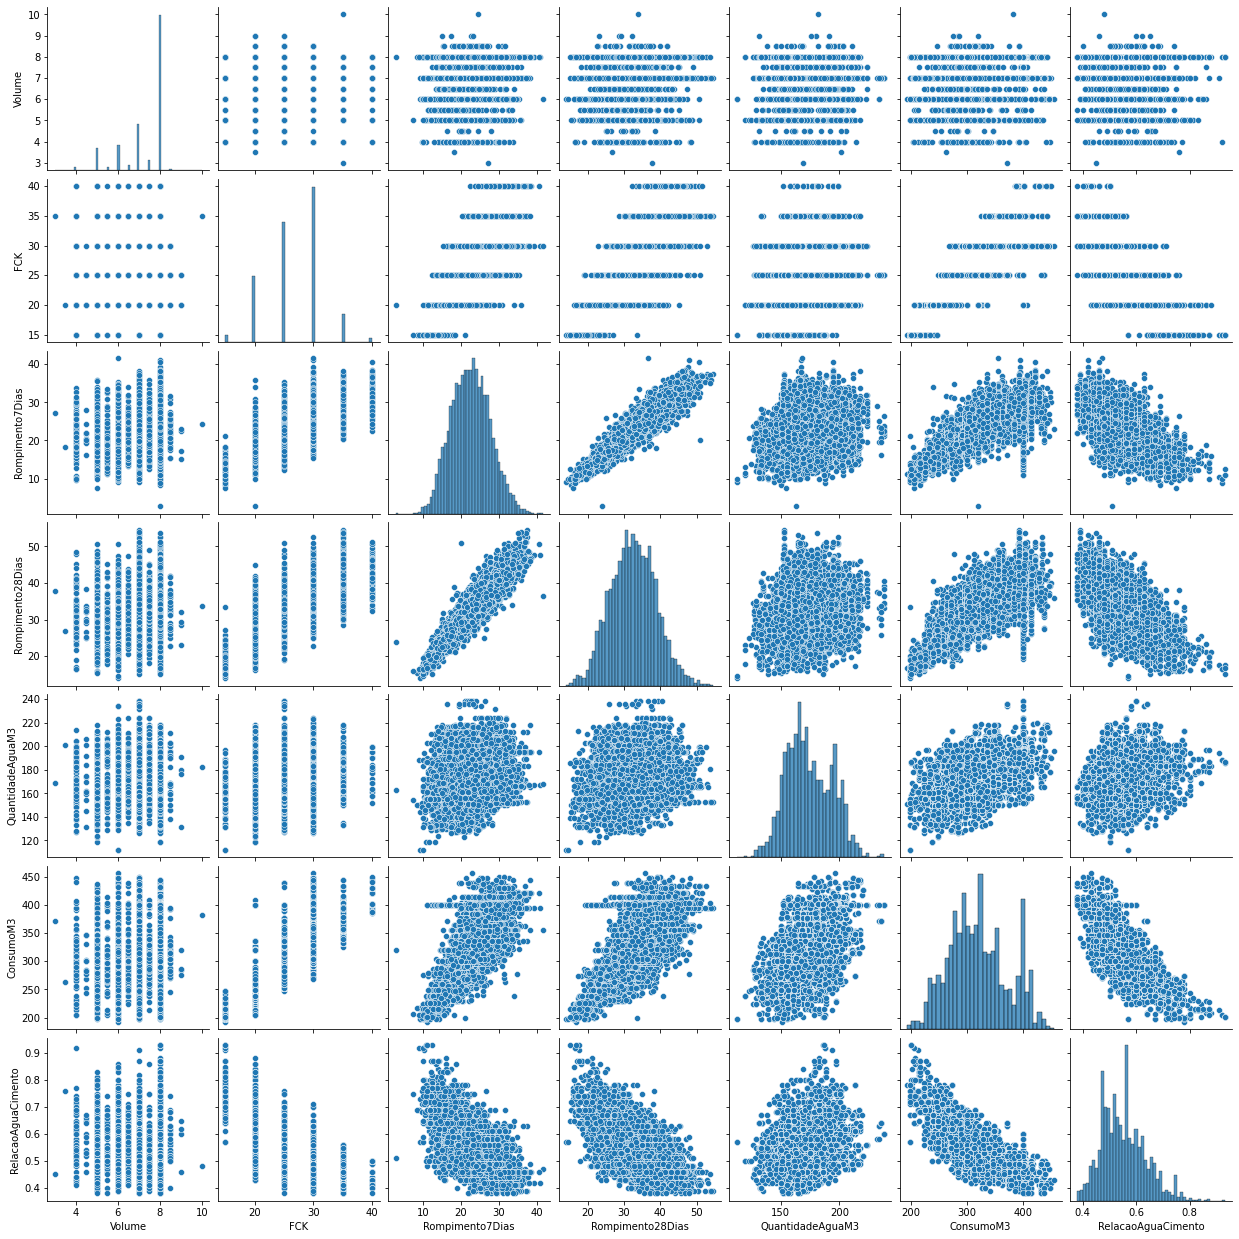

In [24]:
sns.pairplot(dados_modelo)

#### Análise de Correlação entre as variáveis

O gráfico abaixo, chamado de matriz de correlação, ajuda a identificar as correlações entre as *features*

<AxesSubplot:>

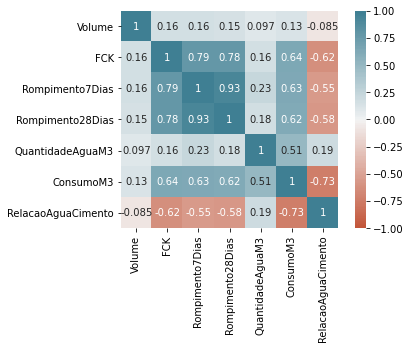

In [25]:
corr = dados_modelo.corr()
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True
)

### Análise de Rompimento28Dias

In [26]:
fig = px.box(dados_modelo, y="Rompimento28Dias", width = 500)
fig.show()

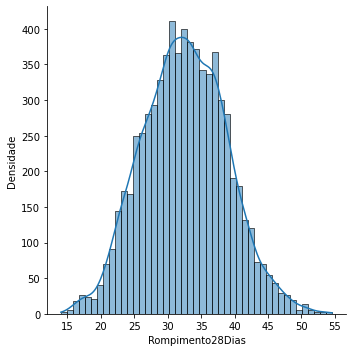

In [27]:
fig = sns.displot(dados_modelo["Rompimento28Dias"], kde=True)
fig.set(ylabel='Densidade')
plt.show()

### Análise de relação entre Rompimento28Dias e demais *features*

In [28]:
fig = px.box(dados_modelo, x="FCK", y="Rompimento28Dias")
fig.show()

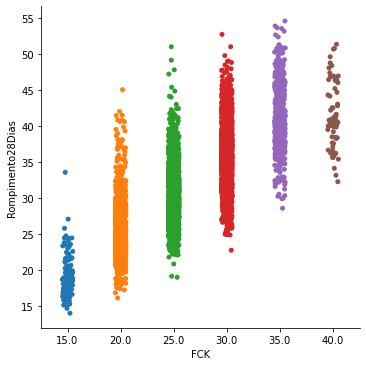

In [29]:
sns.catplot(x="FCK", y="Rompimento28Dias", data=dados_modelo)

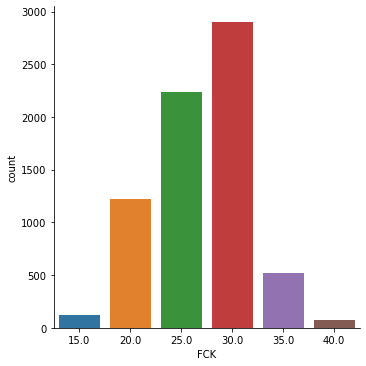

In [30]:
sns.catplot(x="FCK", kind="count", data=dados_modelo)

In [31]:
fig = px.box(dados_modelo, y="Rompimento7Dias", width = 500)
fig.show()

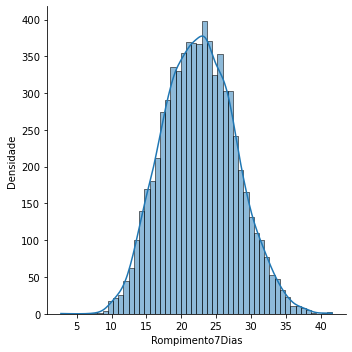

In [32]:
fig = sns.displot(dados_modelo["Rompimento7Dias"], kde=True)
fig.set(ylabel='Densidade')
plt.show()

In [33]:
def MontaDataFrameRompimentos():
    
    df_romp = pd.DataFrame()
    rompimentos = []
    idades = []
    
    
    for i in range(1, len(dados_modelo)):
        romp7Dias = dados_modelo.iloc[i]["Rompimento7Dias"]
        
        if (romp7Dias == np.NaN):
            continue
        else:
            idades.append(7)
            rompimentos.append(romp7Dias)
            
        romp28Dias = dados_modelo.iloc[i]["Rompimento28Dias"]
        
        if (romp28Dias == np.NaN):
            continue
        else:
            idades.append(28)
            rompimentos.append(romp28Dias)
    
    df_romp["Idade"] = idades
    df_romp["Rompimentos"] = rompimentos
    
    return df_romp

In [34]:
df_romp = MontaDataFrameRompimentos()

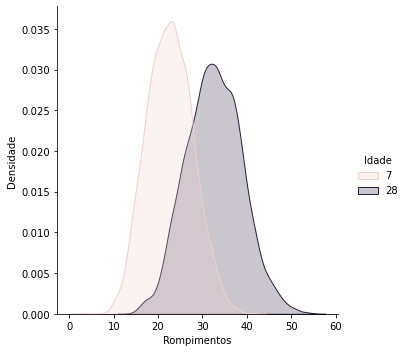

In [35]:
fig = sns.displot(df_romp, x="Rompimentos", hue="Idade", kind="kde", fill=True)
fig.set(ylabel='Densidade')
plt.show()

In [36]:
fig = px.scatter(dados_modelo, x="Rompimento7Dias", y="Rompimento28Dias")
fig.show()

In [37]:
fig = px.scatter(dados_modelo, x="RelacaoAguaCimento", y="Rompimento28Dias")
fig.show()

In [38]:
fig = px.scatter(dados_modelo, x="RelacaoAguaCimento", y="Rompimento28Dias", color = "ConsumoM3")
fig.show()

In [39]:
fig = px.box(dados_modelo, y="RelacaoAguaCimento", width = 500)
fig.show()

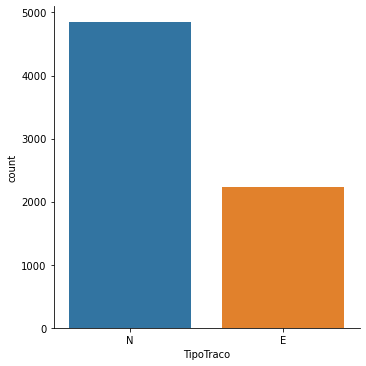

In [40]:
sns.catplot(x="TipoTraco", kind="count", data=dados_modelo)

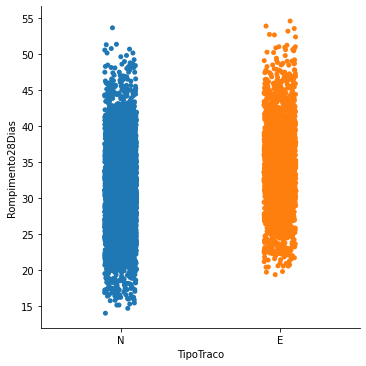

In [41]:
sns.catplot(x="TipoTraco", y="Rompimento28Dias", data=dados_modelo)

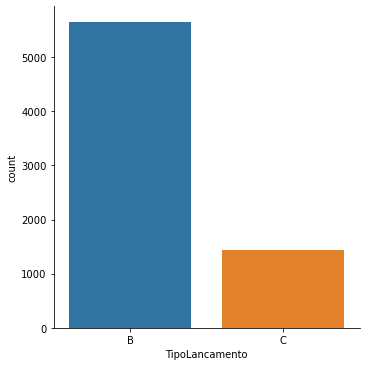

In [42]:
sns.catplot(x="TipoLancamento", kind="count", data=dados_modelo)

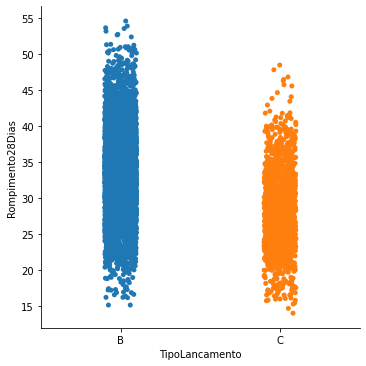

In [43]:
sns.catplot(x="TipoLancamento", y="Rompimento28Dias", data=dados_modelo)

In [44]:
fig = px.scatter(dados_modelo, x="ConsumoM3", y="Rompimento28Dias")
fig.show()

In [78]:
dados_modelo_normais = dados_modelo[dados_modelo["TipoTraco"] == 'E']

fig = px.scatter(dados_modelo_normais, x="ConsumoM3", y="Rompimento28Dias")
fig.show()

In [70]:
dados_modelo_400 = dados_modelo[dados_modelo["ConsumoM3"] == 400]

fig = px.box(dados_modelo_400, x="FCK", y="Rompimento28Dias", color="FCK")
fig.show()

In [75]:
fig = px.scatter(dados_modelo_400, x="QuantidadeAguaM3", y="Rompimento28Dias")
fig.show()